In [1]:
#CTA Immigration views

In [ ]:
suppressPackageStartupMessages({
library(MASS, quietly = TRUE)
library(stringi, quietly = TRUE)
library(wordcloud, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(data.table, quietly = TRUE)
library(stargazer, quietly = TRUE)
library(quanteda, quietly = TRUE)
library(xlsx, quietly = TRUE)
library(stringr, quietly = TRUE)
library(xtable, quietly = TRUE)
    library(mfx, quietly = TRUE)
    library(forcats, quietly = TRUE)
    library(ggalt)
    library(stm)
    library(udpipe)
    library(BTM)
    library(quanteda)
    library(spacyr)
    })

In [14]:
path_data <- ""


In [9]:
gadarian_lemma <- read.csv(paste(path_data,'gadarian_lemmatized.csv',sep=''))

In [10]:
toks_q <- tokens(gadarian_lemma$text,
  remove_punct = TRUE, remove_numbers = TRUE
) %>%
  tokens_tolower()

In [11]:
as.data.frame.tokens <- function(x) {
  data.frame(
    doc_id = rep(names(x), lengths(x)),
#       doc_id = rep(lengths(x)),
    tokens = unlist(x, use.names = FALSE)
  )
}

In [12]:
set.seed(42)
model2 <- BTM(as.data.frame.tokens(toks_q), k = 4, beta = 0.01, iter = 100, trace = 10)

2024-03-27 14:26:48 Start Gibbs sampling iteration 1/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 11/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 21/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 31/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 41/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 51/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 61/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 71/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 81/100
2024-03-27 14:26:48 Start Gibbs sampling iteration 91/100


In [13]:
# Convert to dataframe
df_topic_probabilities <- data.frame(predict(model2, newdata = as.data.frame.tokens(toks_q)))

# Rename the columns
colnames(df_topic_probabilities) <- paste0("topic_", 1:ncol(df_topic_probabilities))

df_topic_probabilities$doc <- rownames(df_topic_probabilities)

# If you want 'doc' to be the first column
df_topic_probabilities <- df_topic_probabilities[, c(ncol(df_topic_probabilities), 1:(ncol(df_topic_probabilities)-1))]
df_topic_probabilities$doc <- as.numeric(gsub("text", "", df_topic_probabilities$doc))
df_topic_probabilities <- df_topic_probabilities[order(df_topic_probabilities$doc), ]
rownames(df_topic_probabilities) <- NULL

In [16]:
write.csv(df_topic_probabilities, 
          paste(path_data,"btm_gadarian_topic_probabilities.csv",sep=''),
          row.names = FALSE)

In [17]:
# Get top words for each topic
top_words <- terms(model2, top_n = 5)

# Initialize an empty dataframe
df_top_words <- data.frame(matrix(ncol = length(top_words), nrow = 1))

# Fill the dataframe
for (i in 1:length(top_words)) {
  df_top_words[,i] <- paste(top_words[[i]]$token, collapse = ", ")
}

# Rename the columns
colnames(df_top_words) <- paste0("topic_", 1:ncol(df_top_words))


In [18]:
write.csv(df_top_words, 
          paste(path_data,"btm_gadarian_top_words.csv",sep=''), 
          row.names = FALSE)

In [19]:
#stm

temp<-textProcessor(documents=gadarian_lemma$text,metadata=gadarian_lemma,stem = FALSE)
out <- prepDocuments(temp$documents, temp$vocab, temp$meta)


Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Creating Output... 
Removing 662 of 1068 terms (662 of 3404 tokens) due to frequency 
Removing 4 Documents with No Words 
Your corpus now has 345 documents, 406 terms and 2742 tokens.

In [20]:
set.seed(42)
mod.out <- stm(out$documents, out$vocab, 4,seed=42,
prevalence=~treatment, data=out$meta,max.em.its = 1000)


Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	....
	 Recovering initialization...
 	....
Initialization complete.
...................................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -5.594) 
...................................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -5.451, relative change = 2.554e-02) 
...................................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -5.391, relative change = 1.097e-02) 
..........................................................................................................

In [21]:
stm_topic_proportions <- as.data.frame(mod.out$theta)
# Get the number of topics
num_topics <- ncol(stm_topic_proportions)

# Create the new column names
new_colnames <- paste0("topic_", 1:num_topics)

# Assign the new column names to the dataframe
colnames(stm_topic_proportions) <- new_colnames


In [22]:
stm_topic_proportions$treatment <- out$meta$treatment

In [23]:
stm_topic_proportions$fear_ra1 <- out$meta$fear_ra1
stm_topic_proportions$fear_ra2 <- out$meta$fear_ra2

In [24]:
write.csv(stm_topic_proportions, 
          paste(path_data,"stm_gadarian_topic_probabilities.csv",sep=''),
          row.names = FALSE)

In [25]:
# Get the top 5 words for each topic
top_words <- labelTopics(mod.out, n=5)

# Convert the matrix to a dataframe
stm_top_words <- as.data.frame(t(top_words$prob))

# Convert the top words for each topic to a single string, separated by a comma
stm_top_words <- apply(stm_top_words, 2, paste, collapse = ", ")

# Convert the matrix back to a dataframe
stm_top_words <- as.data.frame(t(stm_top_words))

# Assign the new column names to the dataframe
colnames(stm_top_words) <- new_colnames

In [26]:
stm_top_words

topic_1,topic_2,topic_3,topic_4
<chr>,<chr>,<chr>,<chr>
"people, country, pay, citizen, english","immigrant, immigration, border, work, security","illegal, legal, worry, welfare, crime","job, come, think, need, americans"


In [27]:
write.csv(stm_top_words, 
          paste(path_data,"stm_gadarian_top_words.csv",sep=''), 
          row.names = FALSE)

In [ ]:
# Make plots

In [28]:
library(ggalt)

In [29]:
tsne_df_step1 <- read.csv("tsne_df_step1.csv", row.names = 1)
tsne_df_step2 <- read.csv("tsne_df_step2.csv", row.names = 1)
tsne_df_step3 <- read.csv("tsne_df_step3.csv", row.names = 1)


In [30]:
# Define the subset of words and their corresponding groups

cluster_list_groups <- list(c('job', 'work', 'worker'),
 c('pay', 'money', 'cost'),
 c('illegal', 'illegally', 'legally'),
 c('come', 'bring', 'get', 'want', 'need', 'give', 'take'))

# Assign colors to each group
group_colors <- c('red', 'blue', 'green', 'orange')




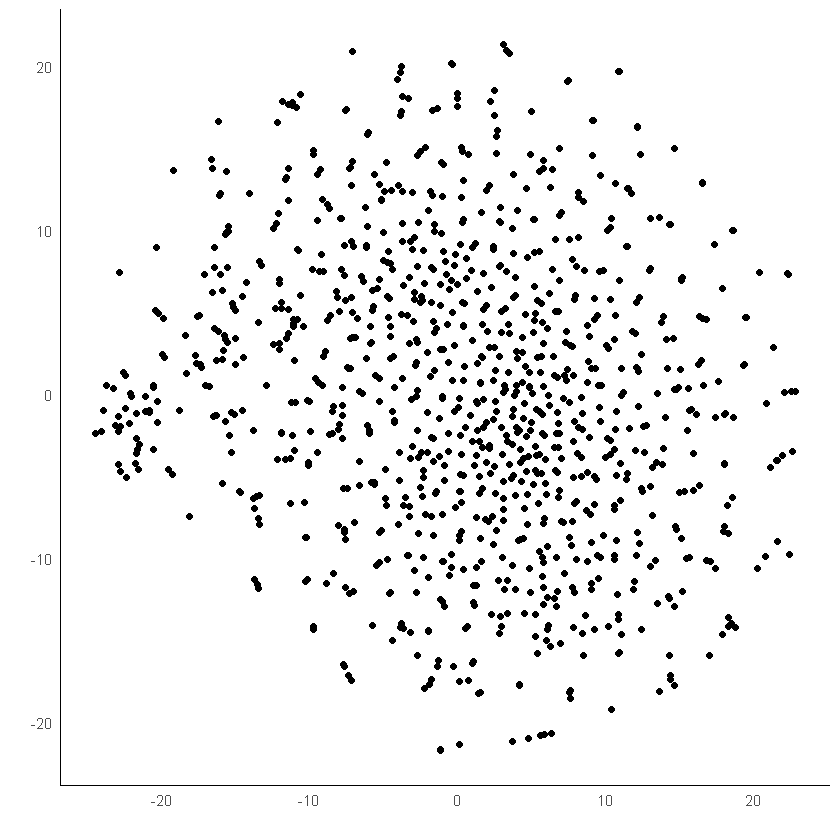

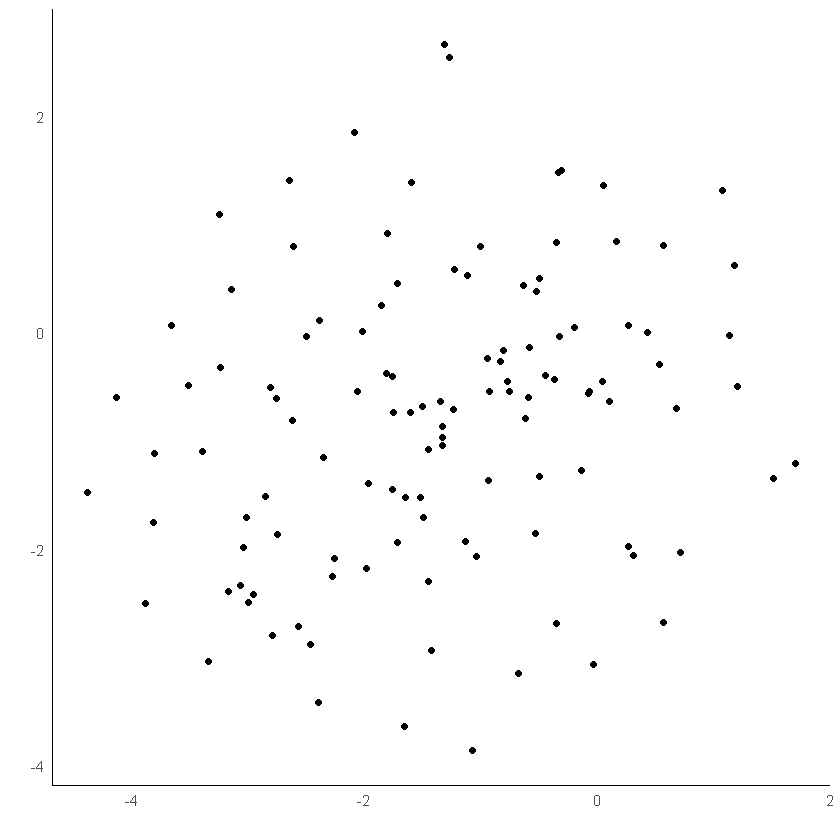

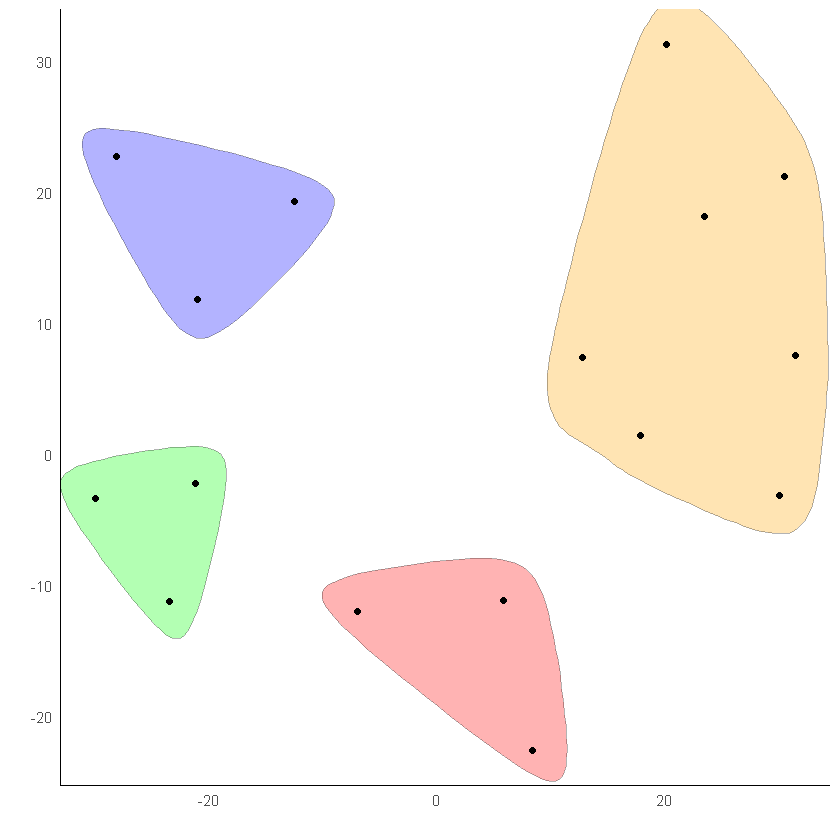

In [31]:
# Plot the word embeddings Step 1
ggplot(tsne_df_step1, aes(X, Y)) +
  geom_point() +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

# Plot the word embeddings Step 2
ggplot(tsne_df_step2, aes(X, Y)) +
  geom_point() +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

# Create the base scatter plot
scatter_plot <- ggplot(tsne_df_step3, aes(X, Y)) +
  geom_point(color = group_colors[rep(1:length(cluster_list_groups), sapply(cluster_list_groups, length))],
             show.legend = FALSE) +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

# Add encircling for each group with colors
encircled_plot <- scatter_plot +
  geom_encircle(data = tsne_df_step3, aes(X, Y, group = rep(1:length(cluster_list_groups), sapply(cluster_list_groups, length))),
                fill = group_colors[rep(1:length(cluster_list_groups), sapply(cluster_list_groups, length))],
                alpha = 0.3, show.legend = FALSE) +
  geom_point(show.legend = FALSE)

# Display the plot
encircled_plot


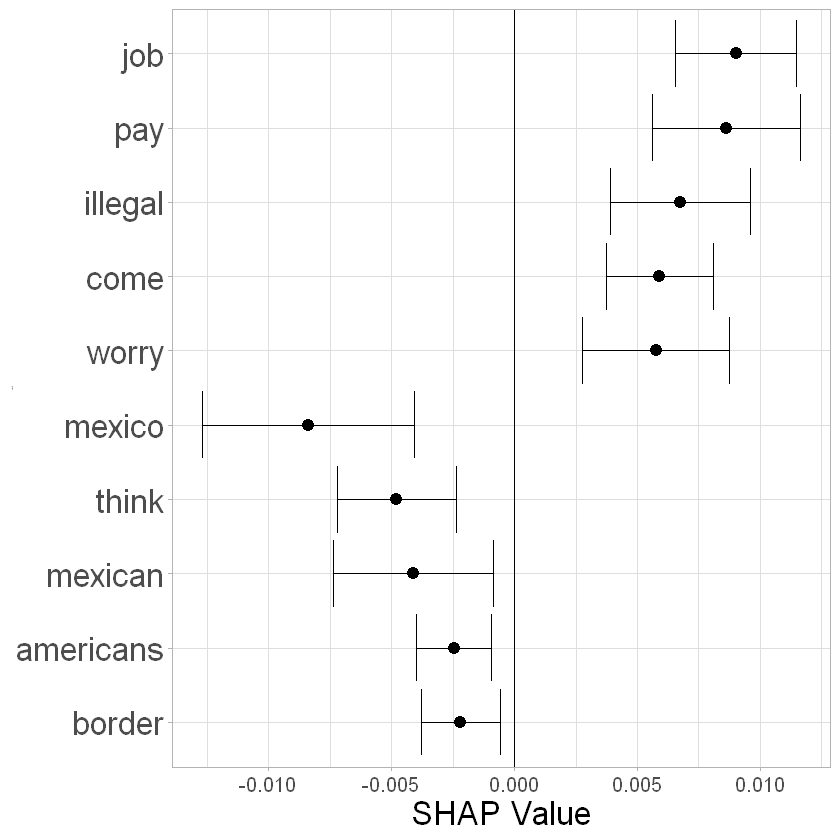

In [42]:
# load X_all
feature_imp <- read.csv("shap_bert_allwords_010324_train_lemma_shap_lemma.csv"
                          ,header = TRUE, sep = ",",row.names = 1)

# compute mean and t-val for each word

words_shap <- data.frame(word=colnames(feature_imp))
words_shap$mean <- 0
words_shap$se <- 0
words_shap$t_val <- 0
words_shap$p_val <- 0


for (i in c(1:nrow(words_shap))){
    word_name <- words_shap$word[i]
    shap_col <- feature_imp[,word_name]
#     shap_col <- shap_col[which(shap_col!=0)]
    words_shap$mean[i] <- mean(shap_col)
#     words_shap$median[i] <- median(shap_col)
    words_shap$se[i] <- sd(shap_col)/sqrt(length(shap_col))
    words_shap$t_val[i] <- abs(words_shap$mean[i]/words_shap$se[i])
#     words_shap$t_val[i] <- abs(words_shap$mean[i]/(words_shap$sd[i]))
    words_shap$p_val[i] <- t.test(feature_imp[,word_name])$p.val
}
words_shap$mean_abs <- abs(words_shap$mean)
words_shap <- words_shap[order(-words_shap$mean_abs),]

n_words <- 5
# word_shap_tmp <- words_shap[which(words_shap$mean>0&words_shap$t_val>1.96),]
word_shap_tmp <- words_shap[which(words_shap$mean>0&words_shap$p_val<0.1),]
words_tmp <- word_shap_tmp[1:n_words,'word']
# words_tmp_corr <- word_shap_tmp[1:n_words,'word_corr']

# word_shap_tmp <- words_shap[which(words_shap$mean<0&words_shap$t_val>1.96),]
word_shap_tmp <- words_shap[which(words_shap$mean<0&words_shap$p_val<0.1),]
words_tmp <- c(words_tmp,word_shap_tmp[1:n_words,'word'])
# words_tmp_corr <-  c(words_tmp_corr,word_shap_tmp[1:n_words,'word_corr'])

shap_words_tmp <- feature_imp[,words_tmp]


# reshape as long datafile

index <- 1
for (i in colnames(shap_words_tmp)){
    n_obs <- nrow(shap_words_tmp)
    if(index==1){
        shap_words_tmp_reshape <- data.frame(shap=shap_words_tmp[,index],word=colnames(shap_words_tmp)[index])
    }else{
        tmp_reshape <- data.frame(shap=shap_words_tmp[,index],word=colnames(shap_words_tmp)[index])
        shap_words_tmp_reshape <- rbind(shap_words_tmp_reshape,tmp_reshape)
    }
    index <- index+1
}

# shap_words_tmp_reshape <- shap_words_tmp_reshape[which(shap_words_tmp_reshape$shap!=0),]
shap_words_tmp_reshape$word <- fct_rev(factor(shap_words_tmp_reshape$word , levels=colnames(shap_words_tmp)))

min.mean.sd.max <- function(x) {
  r <- c(t.test(x)$"conf.int"[1], t.test(x)$"conf.int"[1], 
         mean(x), t.test(x)$"conf.int"[2], 
         t.test(x)$"conf.int"[2])
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(shap_words_tmp_reshape, aes(x = shap, y = word)) + 
  geom_vline(xintercept =0) + 
  theme_light() + 
  xlab("SHAP Value") +
  theme(axis.title.x = element_text(size = 20),
        axis.text.x = element_text(size = 12),
        axis.title.y = element_text(size =0),
        axis.text.y = element_text(size =20)) +
  stat_summary(fun.data = min.mean.sd.max, geom = "errorbar", size=0.5) +
  stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 3,
    shape = 21,
    fill = "black"
  )

